$$\require{mhchem}$$       

# Homework 8
## Pengfei Cheng 
## AndrewID: pengfeic

# Problem 1: Treating catalyst deactivation

We are interested in catalytic cracking of oil to various products:
\begin{align}
\ce{Gas/oil(A)&->[k_A]Products}
\end{align}
The rate law is $r_A=k_AC_A^2$. Gas oil (A) is fed at a rate of 30 mol/min and a concentration
of 0.075 mol/dm$^3$. You can neglect pressure or volumetric flow rate changes along the reactor.
The catalyst is not allowed to leave the reactor. 

## Part A
The reactor is a 100 L CSTR with 22 kg of catalyst. Calculate the steady-state concentration of A and the steady-state concentration of P. The reaction rate constant $k_A = 600\: dm^6/(kg_{cat}\cdot mol\cdot min)$ at 500 K; assume the reactor is held at 500 K.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, minimize
from scipy.integrate import odeint

In [23]:
V = 100 # L
FA0 = 30 # mol/min
CA0 = 0.075 # mol/L
kA = 600 # L^2/(kg_cat * mol * min)
rho_cat = 22 / V # kg/L
v0 = FA0 / CA0

def dCAdt(CA):
    dCdt = CA0 * v0 / V - CA * v0 / V - kA * rho_cat * CA ** 2
    return dCdt

CA, = fsolve (dCAdt, CA0/2)
print ('CA is {:1.4f} mol/L.'.format(CA))
CP = CA0 - CA
print ('CP is {:1.4f} mol/L.'.format(CP))

CA is 0.0349 mol/L.
CP is 0.0401 mol/L.


## Part B
We know that the catalyst activity decreases over time due to deactivation so we need to model this as a transient CSTR  starting with A at 0.075 mol/dm$^3$ an P at 0.010 mol/dm$^3$. The reaction rate decays as $k_A=k_A^0 \exp(- k_D t)$ where $k_D=0.72$/min, $t$ is time, and $k_A^0$ is the rate constant at 500 K (above). Calculate the concentration profile of A and the products P for the first 20 min.

\begin{align*}
    k_A &= k_A^0 e^{-k_Dt} \\
    \frac {d k_A} {d t} &= -k_D k_A^0 e^{-k_Dt}
\end{align*}

$k_A$ is a time-varing variable. We can update the value of $k_A$ by integrating it or calculating its value every time.

1) integrating $k_A$

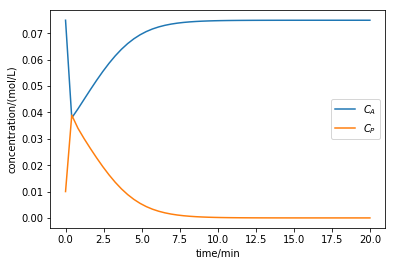

In [25]:
FA0 = 30 # mol/min
C0 = [0.075, 0.010]
kA0 = 600
kD = 0.72

C0 += [kA0]

def dCdt(C, t):
    CA, CP, kA = C
    
    r = kA * rho_cat * CA ** 2
    
    dCAdt = FA0 / V - CA * v0 / V - r
    dCPdt = - CP * v0 / V + r
    dkAdt = - kD * kA0 * np.exp (-kD * t)
    
    return [dCAdt, dCPdt, dkAdt]

tspan = np.linspace (0, 20)

C = odeint (dCdt, C0, tspan)

plt.plot (tspan, C[:,0], tspan, C[:,1])
plt.legend(['$C_A$','$C_P$'])
plt.xlabel('time/min')
plt.ylabel('concentration/(mol/L)')
plt.show()

2) calculaitng $k_A$ every time

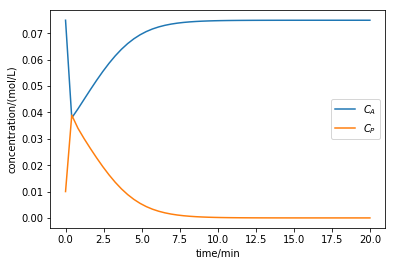

In [27]:
C0 = [0.075, 0.010]

def dCdt(C, t):
    CA, CP = C
    
    kA = kA0 * np.exp (-kD * t)
    
    r = kA * rho_cat * CA ** 2
    
    dCAdt = FA0 / V - CA * v0 / V - r
    # dCPdt = FP0 / V - CP * v0 / V + r
    dCPdt = - CP * v0 / V + r
    
    return [dCAdt, dCPdt]

tspan = np.linspace (0, 20)

C = odeint (dCdt, C0, tspan)

plt.plot (tspan, C[:,0], tspan, C[:,1])
plt.legend(['$C_A$','$C_P$'])
plt.xlabel('time/min')
plt.ylabel('concentration/(mol/L)')
plt.show()

## Part C
You plan to combat the effects of the catalyst decay by increasing the temperature over time.  The activation energy for the reaction is 10 kJ/mol.  Calculate and plot the transient temperature profile necessary to maintain the reactor conversion at the steady state value. The maximum safe temperature for the reactor and process is 1000 K. How long can you maintain this process before violating safety temperature limits and having to recharge the catalyst?

\begin{align*}
    k_A' = k_0 e^{-\frac{E_a}{RT}} e^{-k_Dt} &=k_A^0 = k_0 e^{-\frac{E_a}{RT_0}}\\
    \Rightarrow -\frac{E_a}{RT} - k_D t &= - \frac{E_a}{RT_0} \\
    \Rightarrow T(t) &= \frac {E_a} {R} \frac {1} {\frac{E_a} {RT_0} - k_D t}
\end{align*}

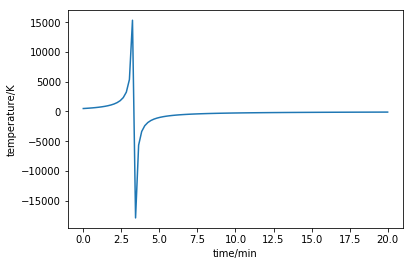

In [28]:
T0 = 500 # K
R = 8.314 # J/mol/K
Ea = 10e3 # J/mol

tspan2 = np.linspace(0, 20, 100)

T = lambda t: Ea / R / (Ea / R / T0 - kD * t)
plt.plot (tspan2, T(tspan2))
plt.xlabel ('time/min')
plt.ylabel ('temperature/K')
plt.show()

There is a discontinuous point at around 3.5 min when $\frac {Ea}{RT_0} = k_D t$. It means that increasing the temperature cannot help maintain the reaction rate no matter how high the temperature is. The temperature after this point is negative and has no physical meanings.

In [6]:
T2 = lambda t: Ea / R / (Ea / R / T0 - kD * t) - 1000
sol, = fsolve (T2, 2)
print ('The process can be maintianed for {:1.2f} min before the temperature reaches 1000 K.'.format(sol))

The process can be maintianed for 1.67 min before the temperature reaches 1000 K.


## Part D
You suggest moving to a moving, packed bed reactor configuration, where the catalyst moves along the reactor length co-currently with the reactants, but at a specified flow rate $U_s$ of $10\:kg/min$.  The packed bed reactor still contains 22 kg of catalyst at all times. You can model this as a normal packed bed reactor, with the rate constant for the catalyst at a specific point in the reactor calculated from its residence time, $\tau$:  $k_A=k_A^0\exp(-k_D\tau)$. This residence time can be calculated as a function of the total mass of catalyst that the reactants have seen, $W$:  $\tau(W)=W/U_s$. Plot the molar flowrate of species A and P as a function of $W$. Assume that we will use a constant reactor temperature of 500 K.

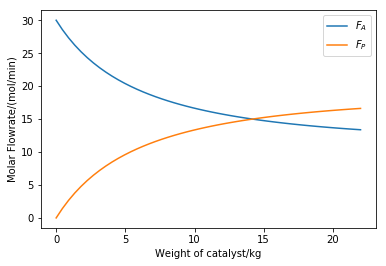

In [7]:
FA0 = 30 # mol/min
Us = 10 # kg/min
F0 = [FA0, 0]

def dFdW(F, W):
    tau = W / Us
    kA = kA0 * np.exp (-kD * tau)
    
    CA = F[0] / v0
    
    r = kA * CA ** 2
    
    dFAdW = -r
    dFPdW = r

    return [dFAdW, dFPdW]

Wspan = np.linspace (0, 22)

F2 = odeint (dFdW, F0, Wspan)
plt.plot (Wspan, F2)
plt.legend(['$F_A$','$F_P$'])
plt.xlabel('Weight of catalyst/kg')
plt.ylabel('Molar Flowrate/(mol/min)')
plt.show()

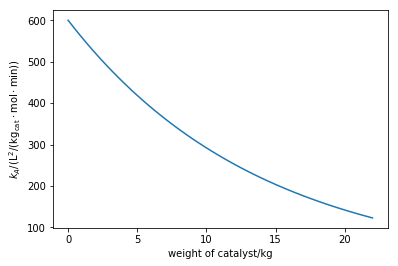

In [30]:
kA = lambda W: kA0 * np.exp (-kD * (W/Us))
plt.plot(Wspan, kA(Wspan))
plt.xlabel ('weight of catalyst/kg')
plt.ylabel ('$k_A/\mathrm{(L^2/(kg_{cat} \cdot mol \cdot min))}$')
plt.show()

The profile of $k_A$ in the packed bed reactor is like the profile in CSTR for $[0, 2.2]$ min, which shows the catalyst maintains relatively high activity.

## Part E
With your new reactor configuration, find the optimal reactant flow rate $v_0$ and catalyst feed rate $U_s$ to maximize profit, and report this profit. Assume you're going to sell all product you make.
Useful information:
- It costs $\$25,000/hr$ to operate the moving bed reactor.
- The gas/oil feed costs \$50/mol.
- Bulk catalyst material costs \$150/kg.
- The products sell for \$200/mol (on an equivalent basis per mol of gas/oil).

Tip: it can help to plot profit as a function of Us and v0 using plt.contour to help identify what is reasonable, just as we did in the bonus for HW5.

In [9]:
c_op = 25000 # $/hr
c_feed = 50 # $/mol
c_cat = 150 # $/kg
c_prod = 200 # $/mol

def ProFun (V, sign = 1):
    v0, Us = V
    
    FA0 = v0 * 0.075 # mol/min
    F0 = [FA0, 0]

    def dFdW2(F, W):
        tau = W / Us
        kA = kA0 * np.exp (-kD * tau)

        CA = F[0] / v0

        r = kA * CA ** 2

        dFAdW = -r
        dFPdW = r

        return [dFAdW, dFPdW]

    F = odeint (dFdW2, F0, Wspan)
    FP_exit = F[-1,1]
    P = c_prod * FP_exit - c_op / 60 - c_feed * FA0 - c_cat * Us
    return P * sign

In [10]:
bnds = ((1e-10, None), (1e-10, None))

sol = minimize(ProFun, [400, 10], args = -1, bounds = bnds)
v0_sol, Us_sol = sol.x
print ('The maximum profit is {:1.2f} $/min, when v0 = {:1.2f} L/min, Us = {:1.2f} kg/min.'.format(-sol.fun, v0_sol, Us_sol))

The maximum profit is 3.90 $/min, when v0 = 403.08 L/min, Us = 7.27 kg/min.


In [11]:
v0_span = np.linspace (0.1, 600, 100)
Us_span = np.linspace (0.1, 10, 100)

v0_mesh, Us_mesh = np.meshgrid (v0_span, Us_span)

Pro = np.empty((100, 100, ))
Pro[:] = np.NAN

for i, v0 in enumerate (v0_span):
    for j, Us in enumerate (Us_span):
        V = [v0, Us]
        Pro[i, j] = ProFun(V)

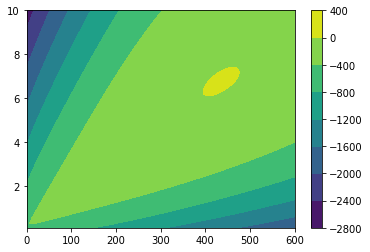

In [31]:
CP = plt.contour(v0_mesh, Us_mesh, Pro, levels = [-2600, 10],
                colors=('k',), linstyles=('-',))
# CCF = plt.contourf(v0_mesh, Us_mesh, Pro)
CPF = plt.contourf(v0_mesh, Us_mesh, Pro)
plt.colorbar(CPF)
plt.show()

## Part F
You complain to your catalyst vendor about how fast the catalyst deactivates, and they suggest you try their new SuperPremium+++ catalyst. It costs \$250/kg but is more resilient and has an improved deactivation rate constant of $k_D=0.3$/min. Will this change be worth it? Decide by calculating the expected profit with this new catalyst.

In [13]:
c_cat2 = 250 # $/kg
kD2 = 0.3 # 1/min

def ProFun2 (V, sign = 1):
    v0, Us = V
    
    FA0 = v0 * 0.075 # mol/min
    F0 = [FA0, 0]

    def dFdW3(F, W):
        tau = W / Us
        kA = kA0 * np.exp (-kD2 * tau)

        CA = F[0] / v0

        # r = kA * rho_cat * CA ** 2
        r = kA * CA ** 2

        dFAdW = -r
        dFPdW = r

        return [dFAdW, dFPdW]

    F = odeint (dFdW3, F0, Wspan)
    FP_exit = F[-1,1]
    P = c_prod * FP_exit - c_op / 60 - c_feed * FA0 - c_cat2 * Us
    return P * sign

In [14]:
bnds = ((1e-10, None), (1e-10, None))

sol2 = minimize(ProFun2, [400, 10], args = -1, bounds = bnds)
v0_sol2, Us_sol2 = sol2.x
print ('The maximum profit is {:1.2f} $/min, when v0 = {:1.2f} L/min, Us = {:1.2f} kg/min.'.format(-sol2.fun, v0_sol2, Us_sol2))

The maximum profit is 406.10 $/min, when v0 = 511.45 L/min, Us = 4.38 kg/min.


In [15]:
v0_span = np.linspace (0.1, 600, 100)
Us_span = np.linspace (0.1, 10, 100)

v0_mesh, Us_mesh = np.meshgrid (v0_span, Us_span)

Pro2 = np.empty((100, 100, ))
Pro2[:] = np.NAN

for i, v0 in enumerate (v0_span):
    for j, Us in enumerate (Us_span):
        V = [v0, Us]
        Pro2[i, j] = ProFun2(V)

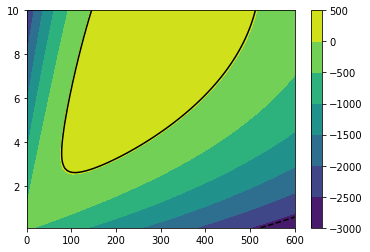

In [16]:
CP2 = plt.contour(v0_mesh, Us_mesh, Pro2, levels = [-2600, 10],
                colors=('k',), linstyles=('-',))
# CCF = plt.contourf(v0_mesh, Us_mesh, Pro)
CPF2 = plt.contourf(v0_mesh, Us_mesh, Pro2)
plt.colorbar(CPF2)
plt.show()

# Problem 2: Catalyst particles

A first-order heterogeneous irreversible reaction is taking place within a spherical catalyst pellet that is plated with platinum throughout the pellet. The reactant concentration halfway between the external surface and the center of the pellet ($r=R/2$) is equal to one tenth the concentration of the pellet's external surface.  The concentration at the external surface is 0.001 g mol /dm^3, the diameter (2R) is $2\times 10^{-3}$cm, and the diffusion coefficient is 0.1 $cm^2/s$.
\begin{align*}
\ce{A->B}
\end{align*}

## Part A
What is the concentration of reactant at a distance of $3\times 10^{-4}$ cm in from the external pellet surface?

In [36]:
De = 0.1 # cm^2/s
R = 1e-3 # cm
CAs = 1e-3 # mol/L

a = R / 3

def SolPhi(phi, r_bar):
    return 3 / r_bar * np.sinh (r_bar * phi) / np.sinh(3 * phi) - 0.1

phi, = fsolve (SolPhi, 1, args= R / 2 / a)

We can solve the problem using the normal or dimensionless form of the equations.

1) Using the normal form

In [37]:
k = phi ** 2 * De / a ** 2
print ('The reaction constant is {:1.2e}/s.'.format(k))

def ode(Y, r):
    WA, CA = Y
    
    rA = k * CA
    
    if r == 0:
        dWAdr = - 2 / (r + 1e-6) * WA + rA / De
    else:
        dWAdr = - 2 / r * WA + rA / De
        
    dCAdr = WA
    
    return [dWAdr, dCAdr]

Rspan = np.linspace(0, R, 200)

def ICFun(CA0):
    Y = odeint (ode, [0, CA0], Rspan)
    #print (Y)
    return Y[-1, 1] - CAs

CA0, = fsolve (ICFun, 1e-4)
print('The concentration is {:1.2e} mol/L at the center of the pellet.'.format(CA0))

Rspan2 = np.linspace (0, R - 3e-4, 200)
Y2 = odeint (ode, [0, CA0], Rspan2)
print('The concentration is {:1.2e} mol/L at a distance of 3×10−4 cm in from the external pellet surface.'.format(Y2[-1, 1]))

The reaction constant is 3.58e+06/s.
The concentration is 3.01e-05 mol/L at the center of the pellet.
The concentration is 2.37e-04 mol/L at a distance of 3×10−4 cm in from the external pellet surface.


2) Using the dimensionless form

In [38]:
def C_bar(phi, r_bar):
    return 3 / r_bar * np.sinh (r_bar * phi) / np.sinh(3 * phi)

CA2 = C_bar(phi, (R - 3e-4)/a) * CAs
print('The concentration is {:1.2e} mol/L at a distance of 3×10−4 cm in from the external pellet surface.'.format(CA2))

The concentration is 2.37e-04 mol/L at a distance of 3×10−4 cm in from the external pellet surface.


## Part B
To what diameter should the pellet be reduced if the effectiveness factor is to be 0.8? 

In [20]:
def eta(phi):
    return  1 / phi * (1 / np.tanh(3 * phi) - 1 / (3 * phi)) - 0.8

phi2, = fsolve (eta, 1)

a2 = (phi2 ** 2 * De / k) ** 0.5
R2 = 3 * a2
print ('The pellet should be reduced to {:1.2e} cm diameter if eta factor is to be 0.8.'.format(R2*2))

The pellet should be reduced to 6.82e-04 cm diameter if eta factor is to be 0.8.
